# ACTIVIDAD 2 PERCEPCION COMPUTACIONAL

Integrantes:   Erika Brand, Diana Rodríguez, Edwar Nieves, William Arevalo, Ronald Cuello

Técnicas de Segmentación Utilizadas:

1. Algoritmo SLIC
2. Segmentación de imagen con autorganización de mapas (SOM)
3. Watershed
4. Algoritmo Quickshif
5. Segmentation - Active contours
6. Algoritmo de segmentación basado en región, con la técnica de Threshold Segmentation

In [1]:
# Cargar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, label2rgb
from skimage import data
from skimage import color
from scipy.ndimage.morphology import binary_closing
from skimage.filters import gaussian
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border)



from skimage.future.graph import rag_mean_color, cut_normalized
import io

from itertools import product
from skimage import io

In [2]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [3]:
# Función para comparar cómo de buena es una determinada segmentación en comparación con el ground truth
# Ambas imagenes deben contener valores True/False
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

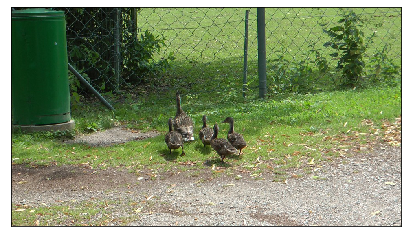

In [6]:
# https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html
patos = io.imread('ducks01_0100.jpg')
gt_patos = rgb2gray(io.imread('ducks01_0100_gt.ppm'))<1


imshow(patos)


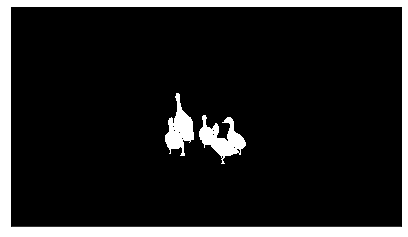

In [7]:
imshow(gt_patos)

# 1. Algoritmo Slic




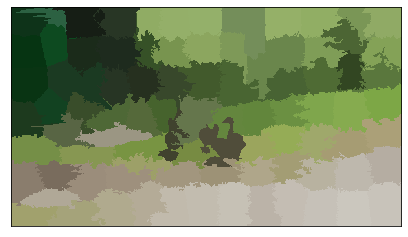

In [8]:
# Se utiliza una segmentación basada en color
labels1 = slic(patos, compactness=20, n_segments = 100, sigma=.5, multichannel=True)
# Para cada segmento, se asocia su valor promedio
out1 = label2rgb(labels1, patos, kind='avg')
imshow(out1)

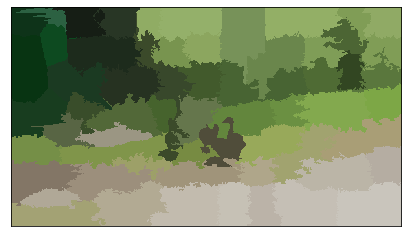

In [9]:
# Se agregan los datos mediante agregación multiescala basada en grafos (RAG)
g = rag_mean_color(patos, labels1, mode='similarity')
# Nos quedamos con 20 elementos, suficientes para tomar un número alto de grupos
labels2 = cut_normalized(labels1, g , 20)
# Para cada segmento se asocia su valor promedio
out2 = label2rgb(labels2, patos, kind='avg')
imshow(out2)

In [10]:
#Convertir los valores a escalas de grises 
gray_out2 = rgb2gray(out2)
#Calculamos el factor f (metrica de exito) para los diferentes segmentos 
results_eval = [factor_f_evaluation(gray_out2==a, gt_patos) for a in np.unique(gray_out2)]

In [11]:
results_eval

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.03928980526918671,
 0.2590285110876452,
 0,
 0.5903037321682371,
 0,
 0,
 0.005009955681161281,
 0,
 0,
 0,
 0,
 0,
 0,
 0.2859918200408998,
 0,
 0.011177312826197404,
 0,
 0.016193291350726127,
 0,
 0,
 0,
 0,
 0.00043925151541772823,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.004611482591653215,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [12]:
# Se ordenan los valor de más éxito a menor
order_results = [results_eval[idx] for idx in np.argsort(results_eval)[::-1]]

#Nos quedamos con el factor f que esta por encima del 10% (Suficientemente grande)

threshold = .1

# Inicializamos una imagen a 0 del mismo tamaño que la imagen original
init_image = np.zeros(gray_out2.shape)

#Acumulamos los segmentos cuyo factor f esta por encima del valor threshold
#Nos quedamos con los segmentos que tienen más coicidencia con
# TO DO: Cambiar range(1,20) por results_eval ordenado y con valores por encima del umbral
for iter_most_significant_values in range (13,14):
    init_image = init_image+(gray_out2 == np.unique(gray_out2)[iter_most_significant_values])



In [13]:
factor_f_evaluation(init_image>0, gt_patos)

0.5903037321682371

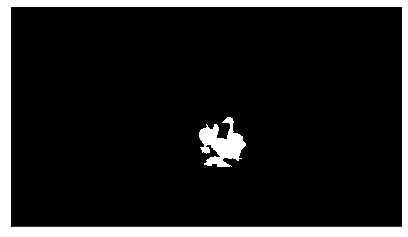

In [14]:
imshow(init_image)

# 2. Segmentación de imagen con autorganización de mapas (SOM)

Un mapa autoorganizado (SOM) es una red de aprendizaje competitiva (una clase interesante
de aprendizaje automático no supervisado), y es uno de los modelos de redes neuronales más populares. En esta forma de trabajo, solo una neurona se activa en un momento dado, por lo que las neuronas de salida compiten entre ellas para ser actividadas. Esta neurona activada se llama winning neuron. Cuando una neurona se dispara, sus vecinos más cercanos tienden a excitarse más que los que están más lejos (definiendo un vecindario topológico con una distancia en descomposición). Como resultado, las neuronas se ven obligadas a organizarse (a través de un proceso de adaptación o aprendizaje) y se crea un mapa de características entre entradas y salidas. Es por esto que esta red se conoce como mapa autoorganizado.

El proceso adaptativo del algoritmo SOM tiene lugar en los siguientes dos pasos:

1. Fase de ordenación (autoorganización): la ordenación topológica de los vectores de peso. Esto toma alrededor de 1,000 iteraciones.
2. Fase de convergencia: en esta fase, el mapa de características se ajusta y forma una cuantificación estadística del espacio de entrada. Típicamente, toma al menos tantas iteraciones como 500 veces el número de neuronas.

In [15]:
#Instalación minisom
!pip install minisom

training...
quantization...
building new image...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: 'shape' argument should be used instead of 'dims'


done.


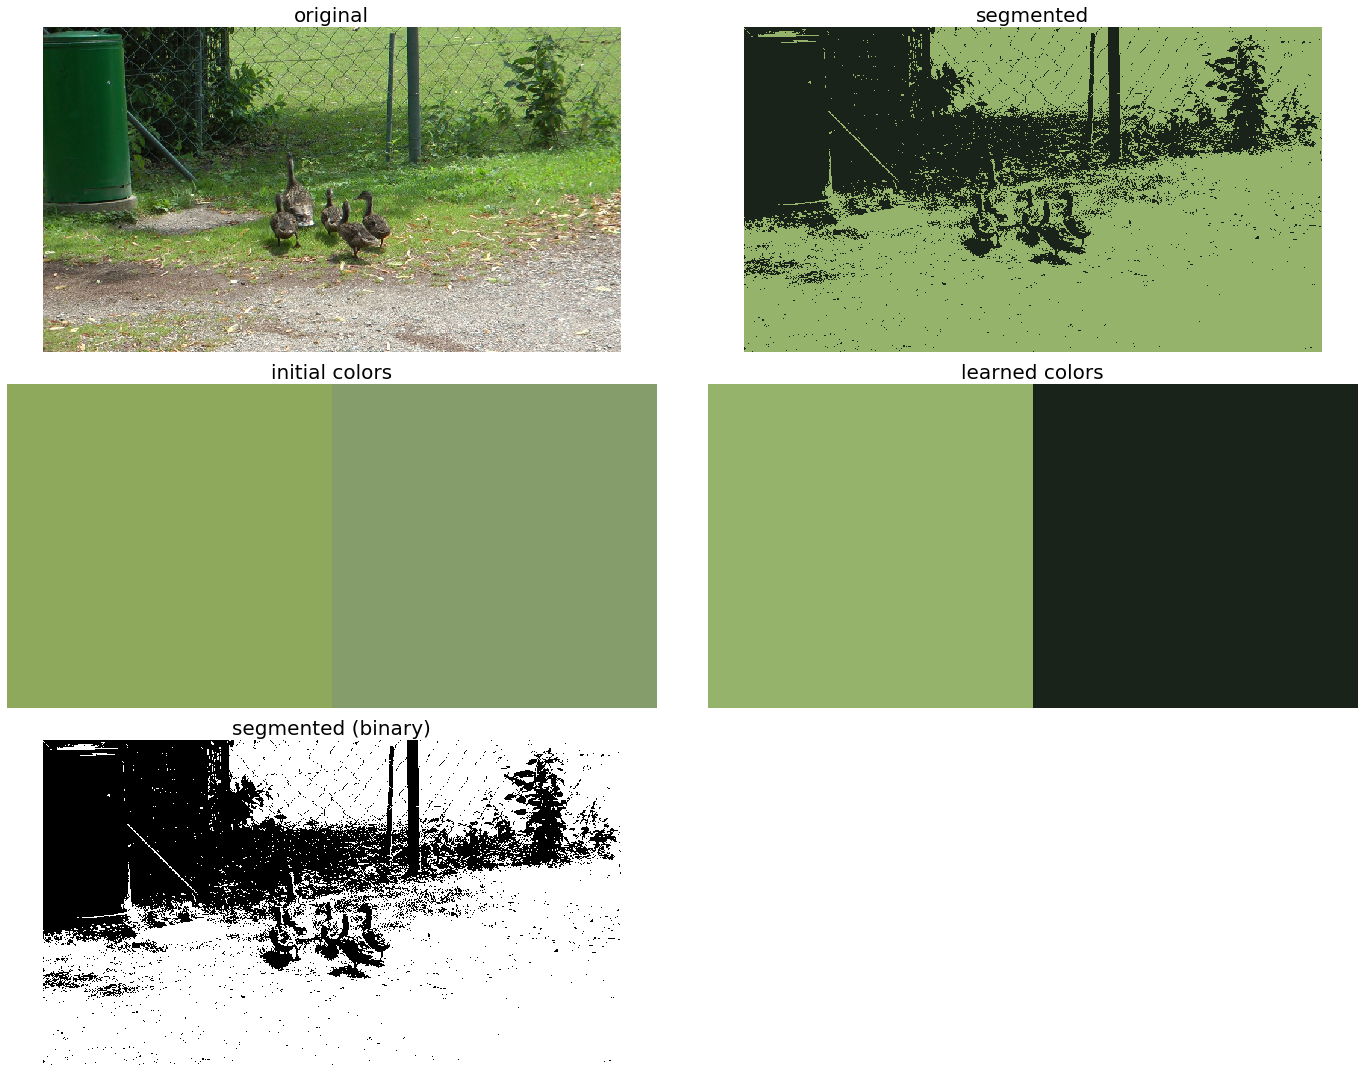

In [17]:
# Se importan las librerias y paquetes requeridos
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt

#1. Se Define la siguiente función para segmentar una imagen de color RGB con SOM. La función acepta
#la imagen de entrada junto con la dimensión de la cuadrícula SOM (nx x ny) y los parámetros σ y n 
#(el número de píxeles aleatorios que se elegirán para entrenar la red, es decir, aprender los vectores de 
#peso en las neuronas). La imagen debe ser aplanada (es decir, cada fila debe representar el RGB valores para un solo píxel)
#antes de que se entrene el SOM

def segment_with_SOM(image, nx, ny, sigma=1., n=500):
    pixels = np.reshape(image, (image.shape[0]*image.shape[1], 3))
    # SOM initialization and training
    print('training...')
    som = MiniSom(x=nx, y=ny, input_len=3, sigma=sigma, learning_rate=0.2)  # nxxny final colors
    som.random_weights_init(pixels)
    starting_weights = som.get_weights().copy()  # saving the starting weights
    som.train_random(pixels, n)
    
# 2. Una vez que se finalice el entrenamiento, se usa SOM para cuantificar todos los píxeles en la imagen (usando el peso
#vectores en cada neurona) con el siguiente fragmento de código.
    
    print('quantization...')
    qnt = som.quantization(pixels)  # quantize each pixels of the image
    
#3. Se reemplazan los valores de píxeles originales por los valores cuantificados con el siguiente código y  se devuelve la
# imagen calculada junto con los pesos en las neuronas.
    
    print('building new image...')
    clustered = np.zeros(image.shape)
    for i, q in enumerate(qnt):  # place the quantized values into a new image
        clustered[np.unravel_index(i, dims=(image.shape[0], image.shape[1]))] = q
    print('done.')
    final_weights = som.get_weights()
    return clustered, starting_weights, final_weights

#4. Se lee la imagen de entrada y se llama a la función para segmentar la imagen en dos grupos (con un 1 x 2
#SOM grid), utilizando la cuantización de SOM. Se traza la imagen binaria segmentada.

from skimage import img_as_float
image = img_as_float(plt.imread('ducks01_0100.jpg'))

clustered, starting_weights, final_weights = segment_with_SOM(image, 1, 2, .1)
colors = np.unique(clustered.reshape(-1,3), axis=0)
clustered_binary = np.zeros_like(clustered)
clustered_binary[np.where((clustered[...,0]==colors[1][0]) & \
                 (clustered[...,1]==colors[1][1]) & \
                 (clustered[...,2]==colors[1][2]))] = 1.

#Si ejecuta este bloque de código y se trazan las imágenes de entrada / salida (con dos grupos), se obtendrá un
# figura como la siguiente:

plt.figure(figsize=(20, 15))
plt.subplot(321), plt.title('original', size=20), plt.axis('off'), plt.imshow(image)
plt.subplot(322), plt.title('segmented', size=20), plt.axis('off'), plt.imshow(clustered)
plt.subplot(323), plt.title('initial colors', size=20), plt.axis('off'), plt.imshow(starting_weights, interpolation='none')
plt.subplot(324), plt.title('learned colors', size=20), plt.axis('off'), plt.imshow(final_weights, interpolation='none')
plt.subplot(325), plt.title('segmented (binary)', size=20), plt.axis('off'), plt.imshow(clustered_binary)
plt.tight_layout()
plt.show()


training...
quantization...
building new image...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: 'shape' argument should be used instead of 'dims'


done.


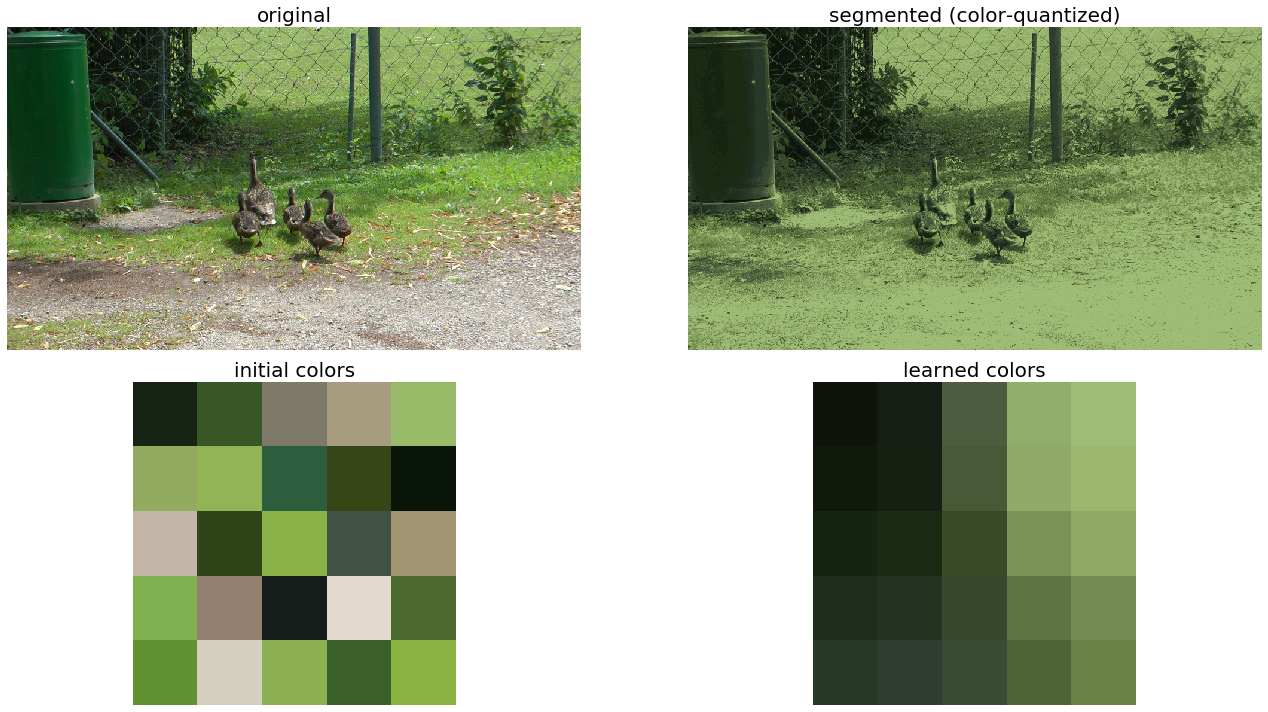

In [18]:
#Si ejecuta las siguientes líneas de código y se trazan las imágenes de entrada / salida (con 25 grupos, a usando 5 x
# 5 SOM grid), se obtendrá una figura como la siguiente:

clustered, starting_weights, final_weights = segment_with_SOM(image, 5, 5)
plt.figure(figsize=(20, 10))
plt.subplot(221), plt.title('original', size=20), plt.axis('off'), plt.imshow(image)
plt.subplot(222), plt.title('segmented (color-quantized)', size=20), plt.axis('off'), plt.imshow(clustered)
plt.subplot(223), plt.title('initial colors', size=20), plt.axis('off'), plt.imshow(starting_weights, interpolation='none')
plt.subplot(224), plt.title('learned colors', size=20), plt.axis('off'), plt.imshow(final_weights, interpolation='none')
plt.tight_layout()
plt.show()

<h4> Comparación de la calidad de segmentación

In [19]:
#Convertir los valores a escalas de grises 
gray_out3 = rgb2gray(clustered)
#Calculamos el factor f (metrica de exito) para los diferentes segmentos 
results_eval2 = [factor_f_evaluation(gray_out3==a, gt_patos) for a in np.unique(gray_out3)]

In [20]:
# Se ordenan los valor de más éxito a menor
order_results = [results_eval2[idx] for idx in np.argsort(results_eval2)[::-1]]

#Nos quedamos con el factor f que esta por encima del 10% (Suficientemente grande)

threshold = .1

# Inicializamos una imagen a 0 del mismo tamaño que la imagen original
init_image = np.zeros(gray_out3.shape)

#Acumulamos los segmentos cuyo factor f esta por encima del valor threshold
#Nos quedamos con los segmentos que tienen más coicidencia con
# TO DO: Cambiar range(1,20) por results_eval ordenado y con valores por encima del umbral
for iter_most_significant_values in range (2,11):
    init_image = init_image+(gray_out3 == np.unique(gray_out3)[iter_most_significant_values])

In [21]:
factor_f_evaluation(init_image>0, gt_patos)

0.08751627986420991

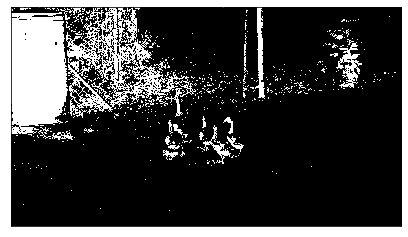

In [22]:
imshow(init_image)

## Segmentación basada en la región
Por lo tanto, intentamos un método basado en la región utilizando la transformación watershed. Primero, un filtrado de pso alto usando el gradiente Sobel de la imagen.

(-0.5, 959.5, 539.5, -0.5)

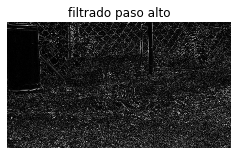

In [23]:
from skimage.filters import sobel

bw = rgb2gray(patos)
elevation_map = sobel(bw)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('filtrado paso alto')
ax.axis('off')


# 3. Watershed

Es un algoritmo clásico utilizado para la segmentación y es especialmente útil cuando se extraen objetos que se tocan o se superponen en imágenes.

Cuando se utiliza el algoritmo de Watershed, debemos comenzar con marcadores definidos por el usuario. Estos marcadores pueden definirse manualmente mediante apuntar y hacer clic, o podemos definirlos de forma automática o heurística mediante métodos como la umbralización y / o las operaciones morfológicas.

[[2 2 2 ... 1 1 1]
 [1 2 2 ... 1 1 1]
 [1 1 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


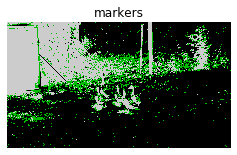

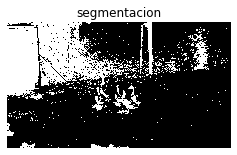

In [24]:
#------------------------
from skimage import morphology

markers = np.zeros_like(bw)

markers[bw < .4] = 1
markers[bw < .3] = 2

#imshow(bw)
#imshow(markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentacion')
ax.axis('off')

print(segmentation)


In [25]:
img_gray_seg = segmentation
#imshow(img_gray_seg)

# Calculamos el factor f (metrica de exito) para los diferentes segmentos 
results_eval = [factor_f_evaluation(segmentation==a, gt_patos) for a in np.unique(segmentation)]
# Se ordenan los valor de más éxito a menor
order_results = [results_eval[idx] for idx in np.argsort(results_eval)[::-1]]

In [26]:
#Nos quedamos con el factor f que esta por encima del 10% (Suficientemente grande)
threshold = .1
# Inicializamos una imagen a 0 del mismo tamaño que la imagen original
init_image = np.zeros(img_gray_seg.shape)

#Acumulamos los segmentos cuyo factor f esta por encima del valor threshold
#Nos quedamos con los segmentos que tienen más coicidencia con
# TO DO: Cambiar range(1,20) por results_eval ordenado y con valores por encima del umbral
for iter_most_significant_values in range (0,1):
    init_image = init_image+(img_gray_seg == np.unique(img_gray_seg)[iter_most_significant_values])

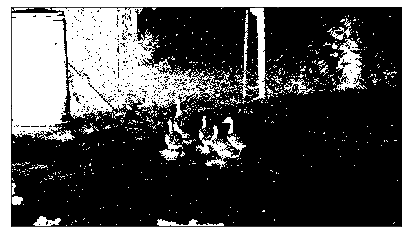

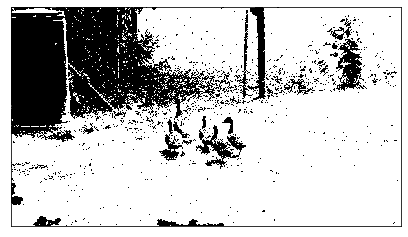

0.027733016707658383


In [27]:
factor = factor_f_evaluation(init_image>0, gt_patos)
imshow(img_gray_seg)
imshow(init_image)
print(factor)

# 4. Segmentando con Quickshift**

Es un algoritmo relativamente reciente para segmentacion de imagenes en 2D, esta basado en apoximación kernelizada. Los parametros principales para el Quickshift son el "sigma" el cual controla la escala de la aproximanción local de densidad. El "max_dist" con el cual se selecciona el nivel jerarquico de segmentacion que se produce y el radio da un trade-off de distance en el color-space y la distancia en la imgagen-espace. 

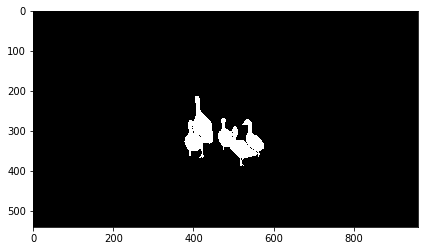

In [28]:
img = io.imread('ducks01_0100.jpg')
img_gray = rgb2gray(img)
gt_patos = rgb2gray(io.imread('ducks01_0100_gt.ppm'))<1


io.imshow(gt_patos)

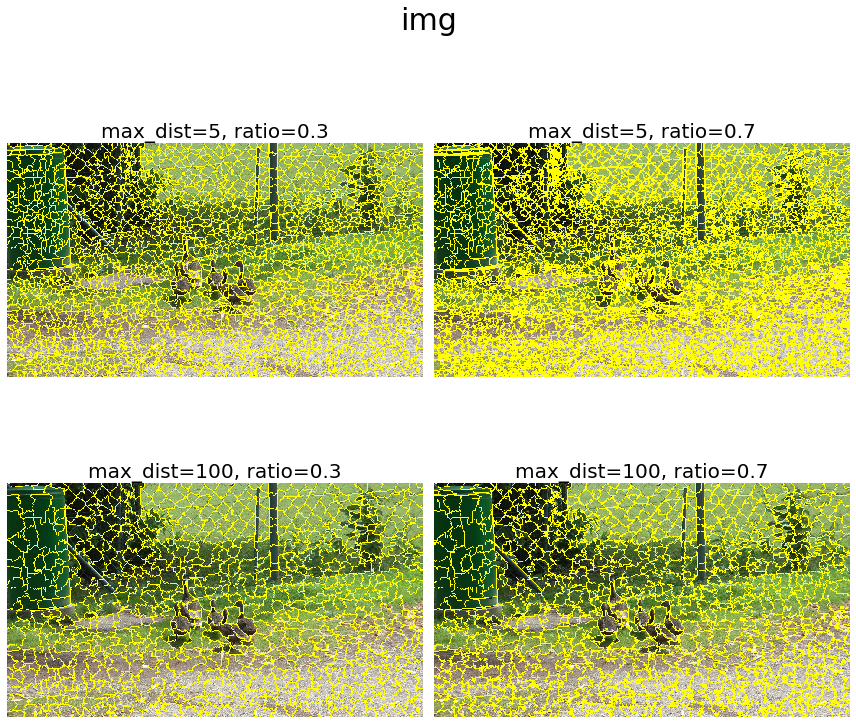

In [29]:
img = io.imread('ducks01_0100.jpg')

def plot_image(img, title):
    plt.imshow(img)
    plt.title(title, size=20)
    plt.axis('off')  


plt.figure(figsize=(12,12))
i = 1
for max_dist in [5, 100]:
    for ratio in [0.3, 0.7]:
        plt.subplot(2,2,i)
        segments_quick = quickshift(img, kernel_size=3, max_dist=max_dist, ratio=ratio)
        plot_image(mark_boundaries(img, segments_quick), 'max_dist=' + str(max_dist) + ', ratio=' + str(ratio))
        i += 1
plt.suptitle('img', size=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



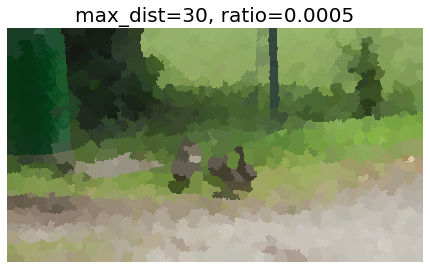

In [30]:
 #Realizo segmentación Quickshif y le agrego parámetros manuales de ratio 0,0005 y max dis= 30, según las imagenes anteriores
# visualmente es la que más nos parece que está bien segmentada.


def plot_image(img, title):
    plt.imshow(img)
    plt.title(title, size=20)
    plt.axis('off')  


plt.figure(figsize=(12,12))
i = 1
for max_dist in [30]:
    for ratio in [0.0005]:
        plt.subplot(2,2,i)
        segments_quick = quickshift(img, kernel_size=3, max_dist=max_dist, ratio=ratio)
        plot_image(mark_boundaries(img, segments_quick), 'max_dist=' + str(max_dist) + ', ratio=' + str(ratio))
        i += 1
        
#plt.show()

from skimage.morphology import watershed


out1 = color.label2rgb(segments_quick, img, kind='avg')

io.imshow(out1)

In [31]:
#Convertir los valores a escalas de grises 
gray_out2 = rgb2gray(out1)
#Calculamos el factor f (metrica de exito) para los diferentes segmentos 
results_eval = [factor_f_evaluation(gray_out2 ==a, gt_patos) for a in np.unique(gray_out2)]

max(results_eval)

#for i, j in enumerate(results_eval):
 #   print (i,j)

0.28590337524818

In [32]:
# Se ordenan los valor de más éxito a menor
order_results = [results_eval[idx] for idx in np.argsort(results_eval)[::-1]]

#Nos quedamos con el factor f que esta por encima del 10% (Suficientemente grande)

threshold = .1

# Inicializamos una imagen a 0 del mismo tamaño que la imagen original
init_image = np.zeros(gray_out2.shape)


#Acumulamos los segmentos cuyo factor f esta por encima del valor threshold
#Nos quedamos con los segmentos que tienen más coicidencia con


#Cambiaremos las metricas con un rango de resultados para validar si el resultado es similar al resultado esperado.
for iter_most_significant_values in range (247,248):
    init_image = init_image+(gray_out2 == np.unique(gray_out2)[iter_most_significant_values])


In [33]:
factor_f_evaluation(init_image>0, gt_patos)

0.28590337524818

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


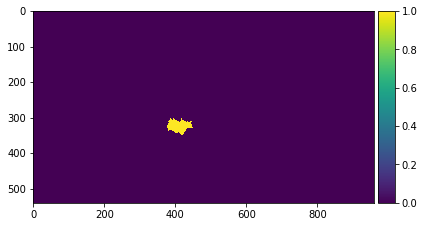

In [34]:
io.imshow(init_image)

# 5. Segmentation - Active contours

In [35]:
gray_ducks=rgb2gray(patos) # Gray Scale
s = np.linspace(0, 2*np.pi, 400) # Vector 1 param start, 2 param stop, 3 param # points
r = 300 + 170*np.sin(s) # Y
c = 480 + 170*np.cos(s) # X
init = np.array([r, c]).T
print(f"""s type: {type(s)}, shape {s.shape}
r type: {type(r)}, shape {r.shape}
c type: {type(c)}, shape {c.shape}
init type: {type(init)}, shape {init.shape}""")

s type: <class 'numpy.ndarray'>, shape (400,)
r type: <class 'numpy.ndarray'>, shape (400,)
c type: <class 'numpy.ndarray'>, shape (400,)
init type: <class 'numpy.ndarray'>, shape (400, 2)


In [36]:
snake = active_contour(gaussian(gray_ducks, 4, multichannel=False),
                       init, alpha=0.045, beta=1e-5, gamma=0.0001,
                       coordinates='rc', boundary_condition='periodic',
                       w_edge=1)

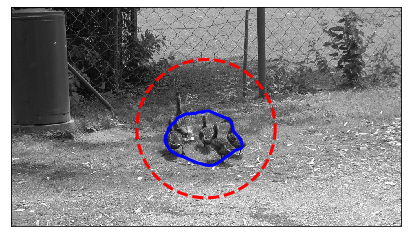

In [37]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray_ducks, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, patos.shape[1], patos.shape[0], 0])

plt.show()

# 6. Algoritmo de segmentación basado en región, con la técnica de Threshold Segmentation




Segmentación basada en regiones:
Una manera simple de segmentar diferentes objetos podría ser usar sus valores de píxeles. Un punto importante a tener en cuenta: los valores de píxeles serán diferentes para los objetos y el fondo de la imagen si hay un fuerte contraste entre ellos.

Se puede establecer un valor umbral. Los valores de píxeles que caen por debajo o por encima de ese umbral se pueden clasificar en consecuencia (como un objeto o el fondo). Esta técnica se conoce como segmentación de umbral (Threshold Segmentation).

gray  (540, 960)


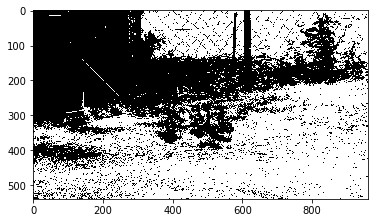

In [39]:
###### Algoritmo Region-based Segmentation:   Threshold Segmentation ###### 
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image

# Seleccionar la imagen
image = plt.imread('ducks01_0100.jpg')
image.shape
plt.imshow(image)

#Convertir imagen a escala de grises
gray = rgb2gray(image)
plt.imshow(gray, cmap='gray')
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])

# Se realiza un cálculo para cada pixel de la imagen, con el fin de detectar si su valor respecto a un umbral 
# Se toma la mediana como umbral, si el valor del pixel es mayor que el umbral, entonces el pixel pertenece al objeto de la imagen
# Si el valor si el valor del pixel es menor que el umbral, entonces ese pixel es el background o paisaje
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

# Se determinan varios umbrales para detectar los diferentes objetos de la imagen
gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 50 #8
    elif gray_r[i] > 0.5:
        gray_r[i] = 6 #2
    elif gray_r[i] > 0.25:
        gray_r[i] = 3 #0
    else:
        gray_r[i] = 0 #5
gray = gray_r.reshape(gray.shape[0],gray.shape[1])

# Se imprime el resultado después e implementar la técnica de Threshold Segmentation
print("gray ",gray.shape)
grays = gray.copy()


Después para lograr el constraste en blanco y negro sobre la imagen, se aplica la técnica o filtro de dilatación.
La ditalación es otra operación morfológica básica que expande el tamaño de los objetos en primer plano, suaviza los límites de los objetos y cierra agujeros y huecos en una imagen binaria. 


(540, 960)


<Figure size 432x288 with 0 Axes>

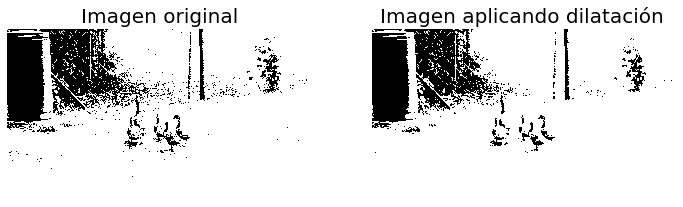

In [40]:
from skimage.morphology import binary_dilation, disk
from skimage.io import imread
import matplotlib.pylab as pylab

# Se define una función para mostrar la diferencia entre la imagen original y el resultado después de aplicar el filtro
def plot_image(image, title=''):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis('off') 

# Se carga la imagen original y se asignan valores de 0 y 1 a los pixeles deacuerdo al valor que tengan
print(grays.shape)
imagen = grays   #rgb2gray(imread('/content/salida.jpg'))
imagen[imagen <= 0.5] = 0
imagen[imagen > 0.5] = 1

# Se imprime el resultado haciendo un comparativo entre la imagen original y el resultado después de aplicar el filtro
pylab.gray()
pylab.figure(figsize=(12,6))

# Imagen original
pylab.subplot(1,2,1), plot_image(imagen, 'Imagen original')

# Imagen con la aplicación del filtro
imagenTecnica = binary_closing(imagen, disk(1))
pylab.subplot(1,2,2), plot_image(imagenTecnica, 'Imagen aplicando dilatación ')
pylab.show()

In [43]:
# Cálculo de los factores f 

# Convertir los valores a escalas de grises 
imagenResultado = rgb2gray(imagenTecnica)

# Se carga la imagen de referencia con la cual se van la imagen modificad en escala de grises
ref_patos = rgb2gray(io.imread('ducks01_0100_gt.ppm'))<1

# Se calcula el rango de los factores f de la comparación
evaluacionResult = [factor_f_evaluation(imagenResultado==a, ref_patos) for a in np.unique(imagenResultado)]
evaluacionResult

[0.08067476438926811, 0.03432620922384702]

0.08067476438926811


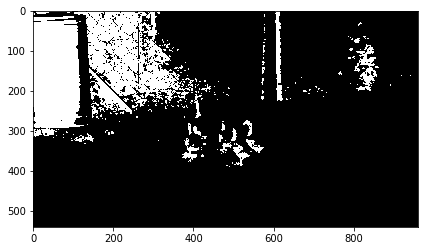

In [44]:
# Selección del mejor factor f

# Se inicializa una imagen a 0 del mismo tamaño que la imagen original para el determinar el resultado final de la comparación
imagenInicializada = np.zeros(imagenResultado.shape)

# Se seleccionan todos los valores obtenidos por la función del factor f y se selecciona el más significante (mayor valor)
for valor_mas_significante in range (0,1):
    imagenInicializada = imagenInicializada+(imagenResultado == np.unique(imagenResultado)[valor_mas_significante])

# Se imprime el valor obtenido junto con la imagen resultado con la aplicación de la técnica de segmentación y el filtro
print(factor_f_evaluation(imagenInicializada>0, gt_patos))
io.imshow(imagenInicializada)


# Conclusiones y justificación de la decision:


Para el trabajo de laboratorio se realizon pruebas con algoritmos de segmentación de la siguiente forma:

* Algoritmo SLIC y se aplicó un crecimiento de region basado 
en grafos, específicamente el multiescala.  El factor f máximo obtenido fue de 5,9.

* Algoritmo de Segmentación de imagen con autorganización de mapas (SOM).El factor f máximo obtenido fue de 0.08

* Algoritmo Watershed filtrado con Sobel.  El factor f máximo obtenido fue de 0.08

* Algoritmo Quickshif con crecimiento de región multiescala. El factor f máximo obtenido fue de 0,28

* Algoritmo Region-based Segmentation con técnica de Threshold Segmentation, y filtro de dilatación. El factor f máximo obtenido fue de 0,08.


Por lo anterior, nuestra decisión es usar como algoritmo prioritario para el ejercicio el SLIC, el cual se acercó al resultado de la imagen entregada para el laboratorio.  
Esto también nos llevó a concluir que no todas las técnicas son apropiadas para todas las imágenes, esto es debido a que para cada imagen es necesario verificar sus componenentes como color, fondo, constraste, brillo, entre otros, y definir que se tipo de imagen se quiere obtener, esto conduce a que se debe determinar la técnica más adecuada para lograr el objetivo deseado.

***Integrantes:***

**Erika Brand, Diana Rodríguez, Edwar Nieves, William Arevalo, Ronald Cuello**

**TABLA DE VALORACION INDIVIDUAL:**

		

|                                                            | Sí | No | Aveces | 
|:----------------------------------------------------------  |----|----|--------|
| Todos los miembros se han integrado al trabajo del grupo   |  X  |    |        | 
| Todos los miembros participan activamente                  |  X  |    |        | 
| Todos los miembros respetan otras ideas aportadas          |  X  |    |        |
| Todos los miembros participan en la elaboración del informe|  X  |    |        | 
| Me he preocupado por realizar un trabajo cooperativo con mis compañeros| X   |   |        | 
| Señala si consideras que algún aspecto del trabajo en grupo no ha sido adecuado|    |  X  |        |
